In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th


In [2]:
xs = th.tensor([
    np.array((0,-2.)),
    np.array((0,0.)),
    np.array((-2,0.)),
]).to(th.float32)
zs = th.tensor([
    0.,
    1.,
    0.
]).to(th.float32)

/tmp/ipykernel_2517897/399557340.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  xs = th.tensor([


In [3]:
th.eye(2).repeat(3,1).shape

torch.Size([6, 2])

In [4]:
def forward(xs, points):
    alpha = 10
    W, B = th.eye(2).repeat(len(xs),1), -xs.reshape(-1)
    h = th.nn.functional.linear(points, W, B)
    h = -th.relu(-h)

    W = th.zeros((xs.shape[0], h.shape[1]))
    for i_ in range(xs.shape[0]):
        i = i_*2
        W[i_,i:i+2] = 1

    h = th.nn.functional.linear(h, alpha*W, th.ones((xs.shape[0])))
    h = th.relu(h)

    W = th.ones(len(xs), len(xs)).triu()
    h = th.nn.functional.linear(h, W, th.ones((xs.shape[0])))
    h = th.relu(h)

    return h

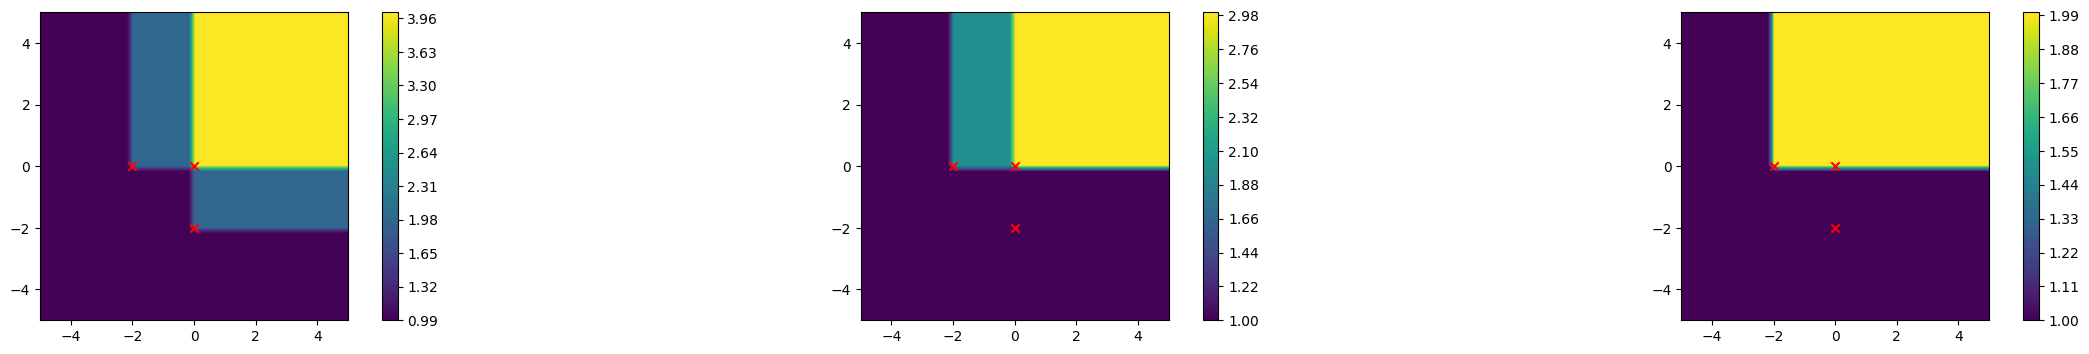

In [5]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
input_data = np.vstack([X.ravel(), Y.ravel()]).T
input_tensor = th.tensor(input_data, dtype=th.float32)
Z = forward(xs, input_tensor).numpy()
plt.figure(figsize=(30, 4))
for i in range(Z.shape[-1]):
    z = Z[...,i].reshape(X.shape)
    plt.subplot(1, Z.shape[-1], i+1)
    plt.gca().set_aspect('equal')
    plt.contourf(X, Y, z, levels=100, cmap='viridis')
    plt.colorbar()
    plt.scatter(xs[:, 0], xs[:, 1], color='red', marker='x')

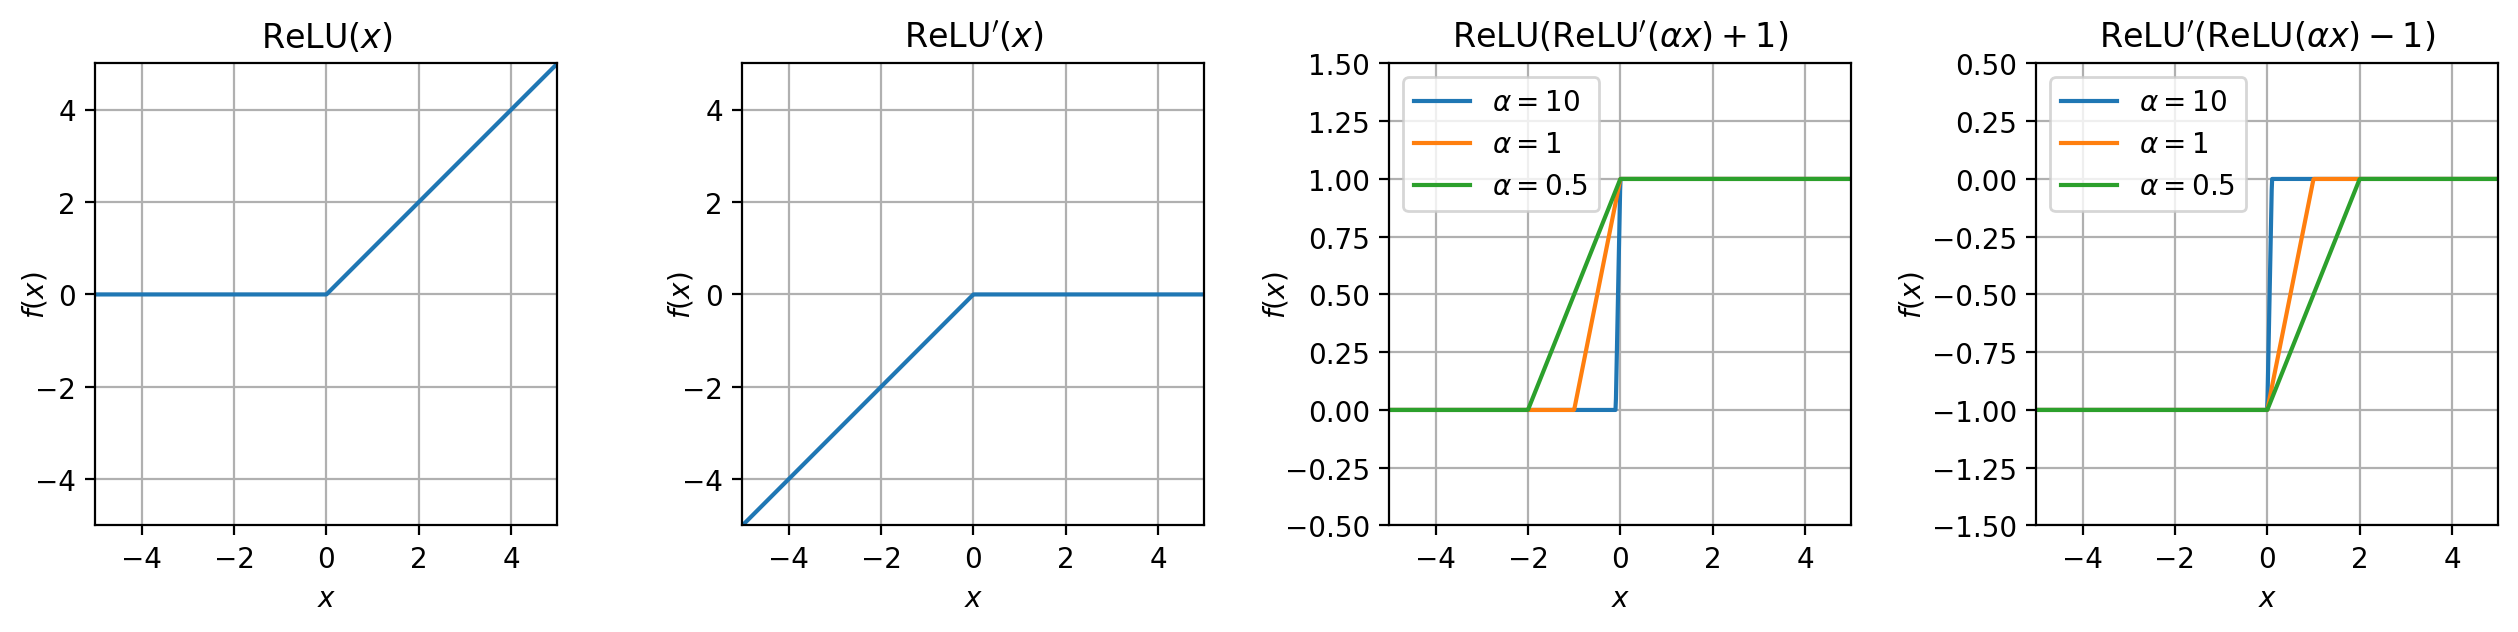

In [6]:
x = np.linspace(-5, 5, 1000)
fig, axs = plt.subplots(1,4, dpi=200, figsize=(16,3))
axs[0].plot(x, np.maximum(0, x))
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[0].grid()
axs[0].set_title("$\\text{ReLU}(x)$")
axs[0].set_aspect('equal')
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f(x)$", labelpad=-5)

axs[1].plot(x, -np.maximum(0, -x))
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].grid()
axs[1].set_title("$\\text{ReLU}'(x)$")
axs[1].set_aspect('equal')
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$f(x)$", labelpad=-5)

axs[2].plot(x, np.maximum(-np.maximum(0, -10*x) + 1,0), label="$\\alpha=10$")
axs[2].plot(x, np.maximum(-np.maximum(0, -1*x) + 1,0), label="$\\alpha=1$")
axs[2].plot(x, np.maximum(-np.maximum(0, -0.5*x) + 1,0), label="$\\alpha=0.5$")
axs[2].set_xlim(-5, 5)
axs[2].set_ylim(-0.5, 1.5)
axs[2].grid()
axs[2].set_title("$\\text{ReLU}(\\text{ReLU}'(\\alpha x)+1)$")
axs[2].legend()
axs[2].set_box_aspect(1)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel("$f(x)$", labelpad=-2)

axs[3].plot(x, -np.maximum(-(np.maximum(0, 10*x) - 1),0), label="$\\alpha=10$")
axs[3].plot(x, -np.maximum(-(np.maximum(0, 1*x) - 1),0), label="$\\alpha=1$")
axs[3].plot(x, -np.maximum(-(np.maximum(0, 0.5*x) - 1),0), label="$\\alpha=0.5$")
axs[3].set_xlim(-5, 5)
axs[3].set_ylim(-1.5, 0.5)
axs[3].grid()
axs[3].set_title("$\\text{ReLU}'(\\text{ReLU}(\\alpha x)-1)$")
axs[3].legend()
axs[3].set_box_aspect(1)
axs[3].set_xlabel("$x$")
axs[3].set_ylabel("$f(x)$", labelpad=2)

plt.savefig("./relu.pdf", bbox_inches='tight')

## Plots

In [7]:
import torch
from torch import nn
from monotonic import *
import numpy as np
from tqdm import trange
x = torch.tensor(np.linspace(-3, 10, 1000)).to(torch.float32).reshape(-1, 1)
y = (np.cos(x)+x).clone().detach().to(torch.float32)

/tmp/ipykernel_2517897/3094779921.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = (np.cos(x)+x).clone().detach().to(torch.float32)


In [8]:
class SimpleLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features, requires_grad=True)*0.01)
        self.bias = torch.nn.Parameter(torch.randn(out_features, requires_grad=True)*0.01)

    def forward(self, input):
        return input.mm(self.weight.t().abs()) + self.bias
    
class ReluTwisted(nn.Module):
    def forward(self, input):
        return -torch.relu(-input)

In [9]:
STEPSIZE=0.003

DIM  = 128
our_model = nn.Sequential(
    MonotonicLinear(1, DIM, pre_activation=nn.Identity()),
    MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
    MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
)
bad_model = nn.Sequential(
    SimpleLinear(1, DIM),
    torch.nn.ReLU(),
    SimpleLinear(DIM, DIM),
    torch.nn.ReLU(),
    SimpleLinear(DIM, 1),
)
sigmoid_model = nn.Sequential(
    ConstrainedLinear(1, DIM),
    nn.Sigmoid(),
    ConstrainedLinear(DIM, DIM),
    nn.Sigmoid(),
    ConstrainedLinear(DIM, 1),
)
model = nn.Sequential(
    torch.nn.LazyLinear(DIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(DIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(1),
)
our_opt = torch.optim.Adam(our_model.parameters(), lr=STEPSIZE)
bad_opt = torch.optim.Adam(bad_model.parameters(), lr=STEPSIZE)
opt = torch.optim.Adam(model.parameters(), lr=STEPSIZE)
sigmoid_opt = torch.optim.Adam(sigmoid_model.parameters(), lr=STEPSIZE)

models = [
    ["uncontrained", model, opt],
    ["relu", bad_model, bad_opt],
    ["sigmoid", sigmoid_model, sigmoid_opt],
    ["proposedauto", our_model, our_opt],
]


OTHERDIM = 256
our_model_other = nn.Sequential(
    MonotonicLinear(1, OTHERDIM, pre_activation=nn.Identity()),
    MonotonicLinear(OTHERDIM, OTHERDIM, pre_activation=nn.ReLU()),
    MonotonicLinear(OTHERDIM, 1, pre_activation=nn.ReLU()),
)
bad_model_other = nn.Sequential(
    SimpleLinear(1, OTHERDIM),
    torch.nn.ReLU(),
    SimpleLinear(OTHERDIM, OTHERDIM),
    torch.nn.ReLU(),
    SimpleLinear(OTHERDIM, 1),
)
sigmoid_model_other = nn.Sequential(
    ConstrainedLinear(1, OTHERDIM),
    nn.Sigmoid(),
    MonotonicLinear(OTHERDIM, OTHERDIM),
    nn.Sigmoid(),
    MonotonicLinear(OTHERDIM, 1),
)
model_other = nn.Sequential(
    torch.nn.LazyLinear(OTHERDIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(OTHERDIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(1),
)
our_opt_other = torch.optim.Adam(our_model_other.parameters(), lr=STEPSIZE)
bad_opt_other = torch.optim.Adam(bad_model_other.parameters(), lr=STEPSIZE)
opt_other = torch.optim.Adam(model_other.parameters(), lr=STEPSIZE)
sigmoid_opt_other = torch.optim.Adam(sigmoid_model_other.parameters(), lr=STEPSIZE)

models_other = [
    ["uncontrained", model_other, opt_other],
    ["relu", bad_model_other, bad_opt_other],
    ["sigmoid", sigmoid_model_other, sigmoid_opt_other],
    ["proposedauto", our_model_other, our_opt_other],
]

In [10]:
model_losses = {name: [] for name, _, _ in models}
model_other_losses = {name: [] for name, _, _ in models_other}
for _ in trange(1000):
    for name_, model_, opt_ in models:
        opt_.zero_grad()
        loss_ = torch.nn.functional.mse_loss(model_(x), y)
        loss_.backward()
        opt_.step()
        model_losses[name_].append(loss_.item())
    for name_, model_, opt_ in models_other:
        opt_.zero_grad()
        loss_ = torch.nn.functional.mse_loss(model_(x), y)
        loss_.backward()
        opt_.step()
        model_other_losses[name_].append(loss_.item())

100%|██████████| 1000/1000 [00:18<00:00, 53.38it/s]


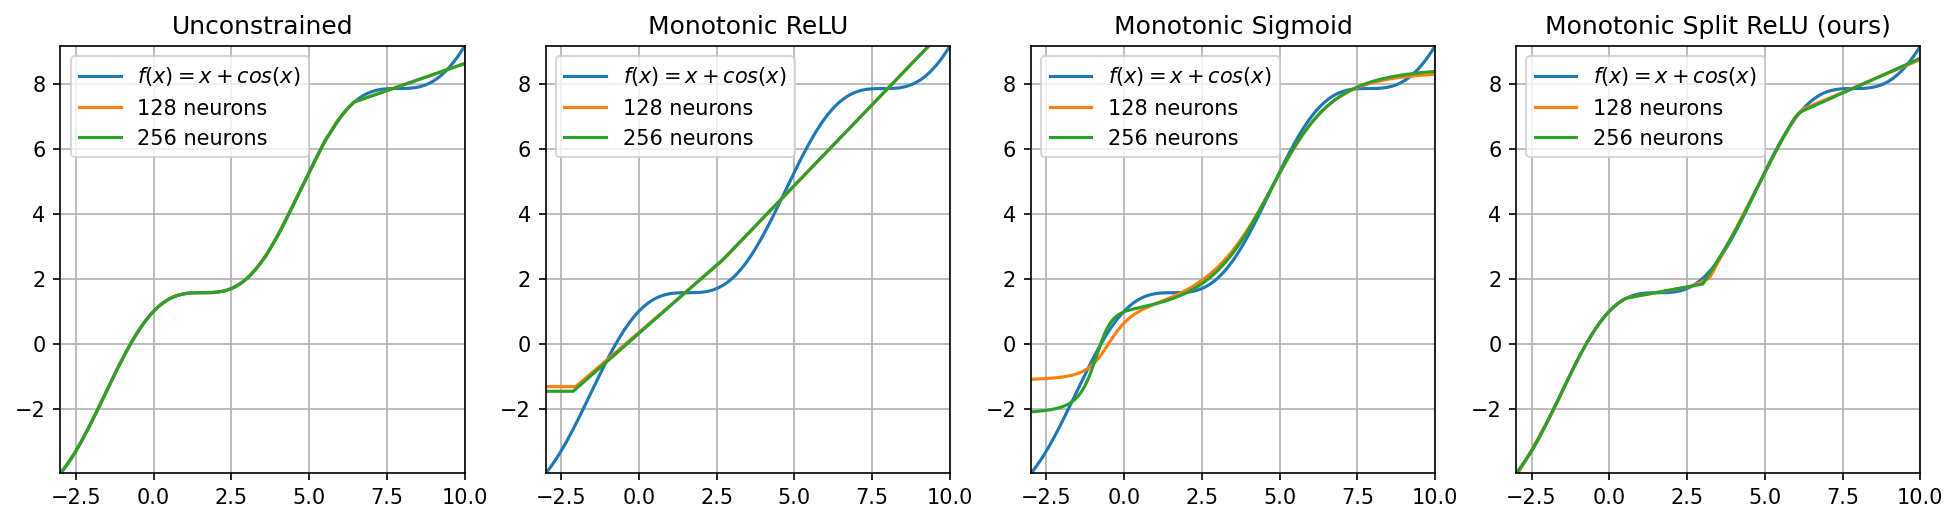

In [11]:
fig, axs = plt.subplots(1, len(models), figsize=(16, 3.7), dpi=150)
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]
for i in range(len(models)):
    axs[i].plot(x,y, label="$f(x)=x+cos(x)$")
    axs[i].plot(x, models[i][1](x).detach(), label=f"{DIM} neurons")
    axs[i].plot(x, models_other[i][1](x).detach(), label=f"{OTHERDIM} neurons")
    axs[i].set_title(titles[i])
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(y.min(), y.max())

plt.savefig("./comparison.pdf")

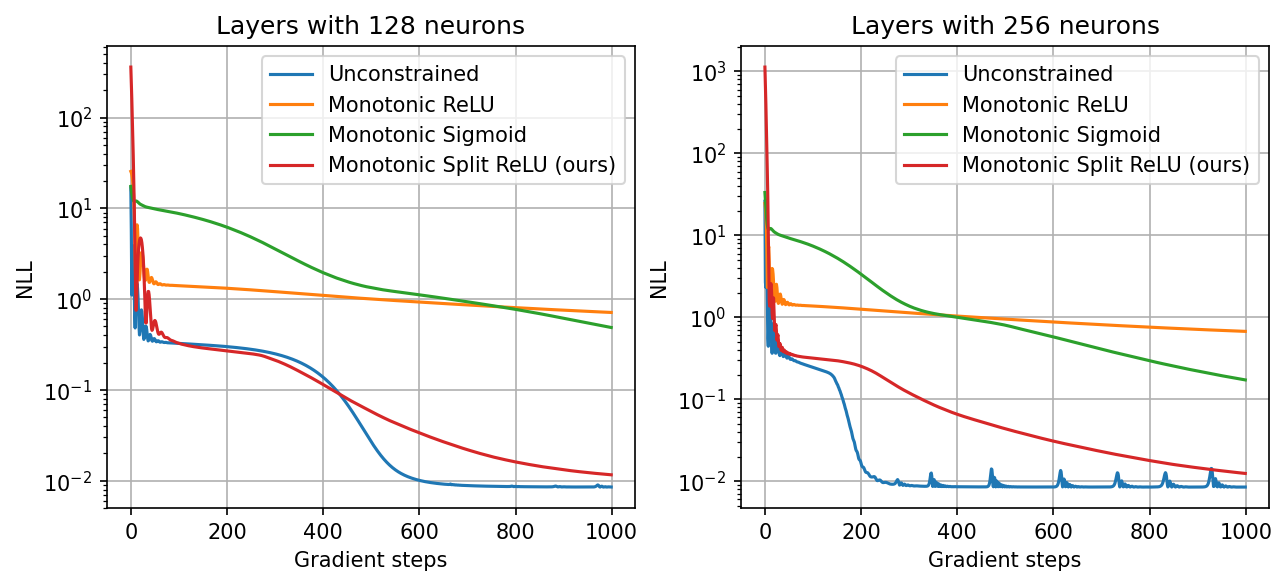

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=150)
for (_, loss), name in zip(model_losses.items(), titles):
    axs[0].semilogy(loss, label=name)

for (_, loss), name in zip(model_other_losses.items(), titles):
    axs[1].semilogy(loss, label=name)

axs[0].set_ylabel("NLL")
axs[1].set_ylabel("NLL")
axs[0].set_xlabel("Gradient steps")
axs[1].set_xlabel("Gradient steps")

axs[0].set_title(f"Layers with {DIM} neurons")
axs[1].set_title(f"Layers with {OTHERDIM} neurons")

axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()

plt.savefig("./losses.pdf")

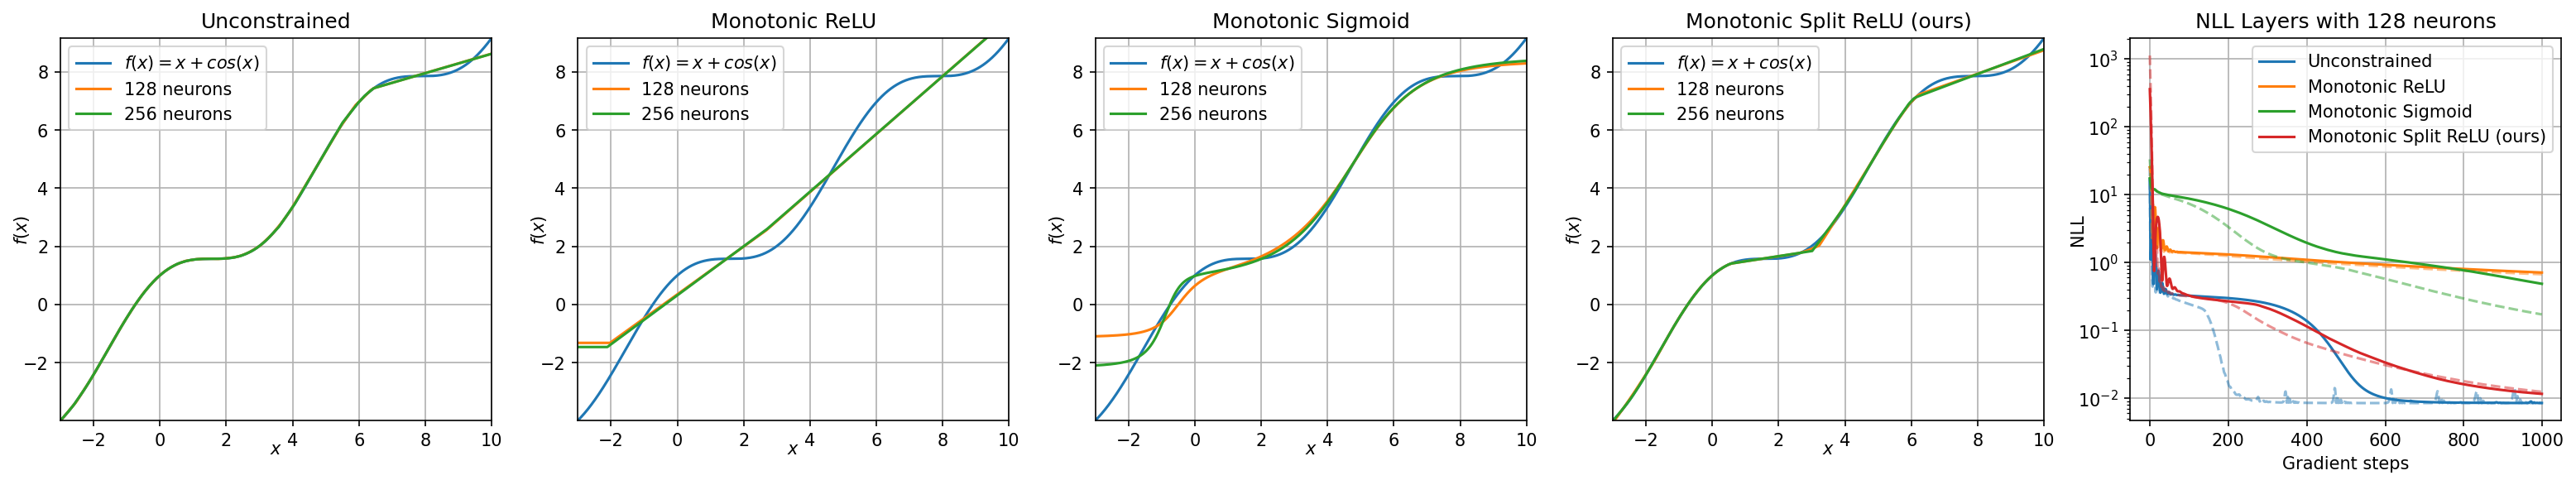

In [13]:
fig, axs = plt.subplots(1, len(models)+1, figsize=(26, 4), dpi=150)
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]
for i in range(len(models)):
    axs[i].plot(x,y, label="$f(x)=x+cos(x)$")
    axs[i].plot(x, models[i][1](x).detach(), label=f"{DIM} neurons")
    axs[i].plot(x, models_other[i][1](x).detach(), label=f"{OTHERDIM} neurons")
    axs[i].set_title(titles[i])
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(y.min(), y.max())
    axs[i].set_ylabel("$f(x)$", labelpad=-5)
    axs[i].set_xlabel("$x$", labelpad=-5)



# for (_, loss), name in zip(model_losses.items(), titles):
#     axs[4].semilogy(loss, label=name)

# for (_, loss), name in zip(model_other_losses.items(), titles):
#     axs[5].semilogy(loss, label=name)
i = 0
for ((_, loss), (_, loss_other)), name in zip(zip(model_losses.items(), model_other_losses.items()), titles):
    axs[4].semilogy(loss, label=name, c=f"C{i}")
    axs[4].semilogy(loss_other, label="_nolabel_", c=f"C{i}", alpha=0.5, linestyle="dashed")
    i+=1

axs[4].set_ylabel("NLL", labelpad=-5)
#axs[5].set_ylabel("NLL", labelpad=-5)
axs[4].set_xlabel("Gradient steps")
#axs[5].set_xlabel("Gradient steps")

axs[4].set_title(f"NLL Layers with {DIM} neurons")
#axs[5].set_title(f"NLL Layers with {OTHERDIM} neurons")

axs[4].legend()
axs[4].grid()
#axs[5].legend()
#axs[5].grid()

plt.savefig("./joint_loss_comparison.pdf", bbox_inches='tight')

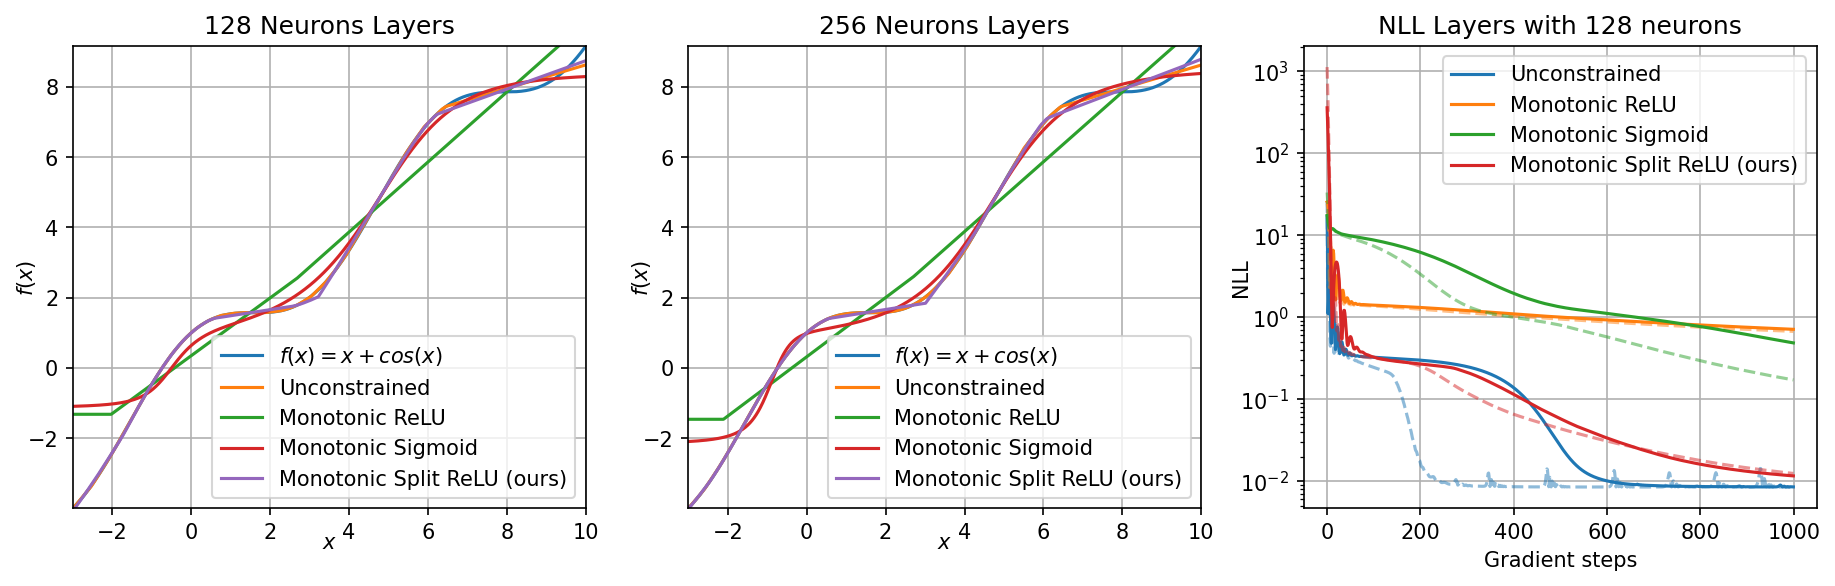

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=150)
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]
axs[0].plot(x,y, label="$f(x)=x+cos(x)$")
axs[0].set_title("128 Neurons Layers")
axs[0].grid()
for i in range(len(models)):
    axs[0].plot(x, models[i][1](x).detach(), label=titles[i])
    axs[0].set_xlim(x.min(), x.max())
    axs[0].set_ylim(y.min(), y.max())
    axs[0].set_ylabel("$f(x)$", labelpad=-5)
    axs[0].set_xlabel("$x$", labelpad=-5)
axs[0].legend()

axs[1].plot(x,y, label="$f(x)=x+cos(x)$")
axs[1].set_title("256 Neurons Layers")
axs[1].grid()
for i in range(len(models)):
    axs[1].plot(x, models_other[i][1](x).detach(), label=titles[i])
    axs[1].set_xlim(x.min(), x.max())
    axs[1].set_ylim(y.min(), y.max())
    axs[1].set_ylabel("$f(x)$", labelpad=-5)
    axs[1].set_xlabel("$x$", labelpad=-5)
axs[1].legend()



# for (_, loss), name in zip(model_losses.items(), titles):
#     axs[4].semilogy(loss, label=name)

# for (_, loss), name in zip(model_other_losses.items(), titles):
#     axs[5].semilogy(loss, label=name)
i = 0
for ((_, loss), (_, loss_other)), name in zip(zip(model_losses.items(), model_other_losses.items()), titles):
    axs[2].semilogy(loss, label=name, c=f"C{i}")
    axs[2].semilogy(loss_other, label="_nolabel_", c=f"C{i}", alpha=0.5, linestyle="dashed")
    i+=1

axs[2].set_ylabel("NLL", labelpad=-5)
#axs[5].set_ylabel("NLL", labelpad=-5)
axs[2].set_xlabel("Gradient steps")
#axs[5].set_xlabel("Gradient steps")

axs[2].set_title(f"NLL Layers with {DIM} neurons")
#axs[5].set_title(f"NLL Layers with {OTHERDIM} neurons")

axs[2].legend()
axs[2].grid()
#axs[5].legend()
#axs[5].grid()

plt.savefig("./joint_loss_comparison_accorpated.pdf", bbox_inches='tight')

/tmp/ipykernel_2517897/397434194.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].semilogy(x, np.convolve(np.square(models[i][1](x).detach()-y).squeeze(), np.ones((20,)), mode="same"), label=titles[i],c=f"C{i}",)
/tmp/ipykernel_2517897/397434194.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].semilogy(x, np.convolve(np.square(models_other[i][1](x).detach()-y).squeeze(), np.ones((20,)), mode="same"), label="_nolabel_", alpha=0.5, linestyle="dashed",c=f"C{i}",)


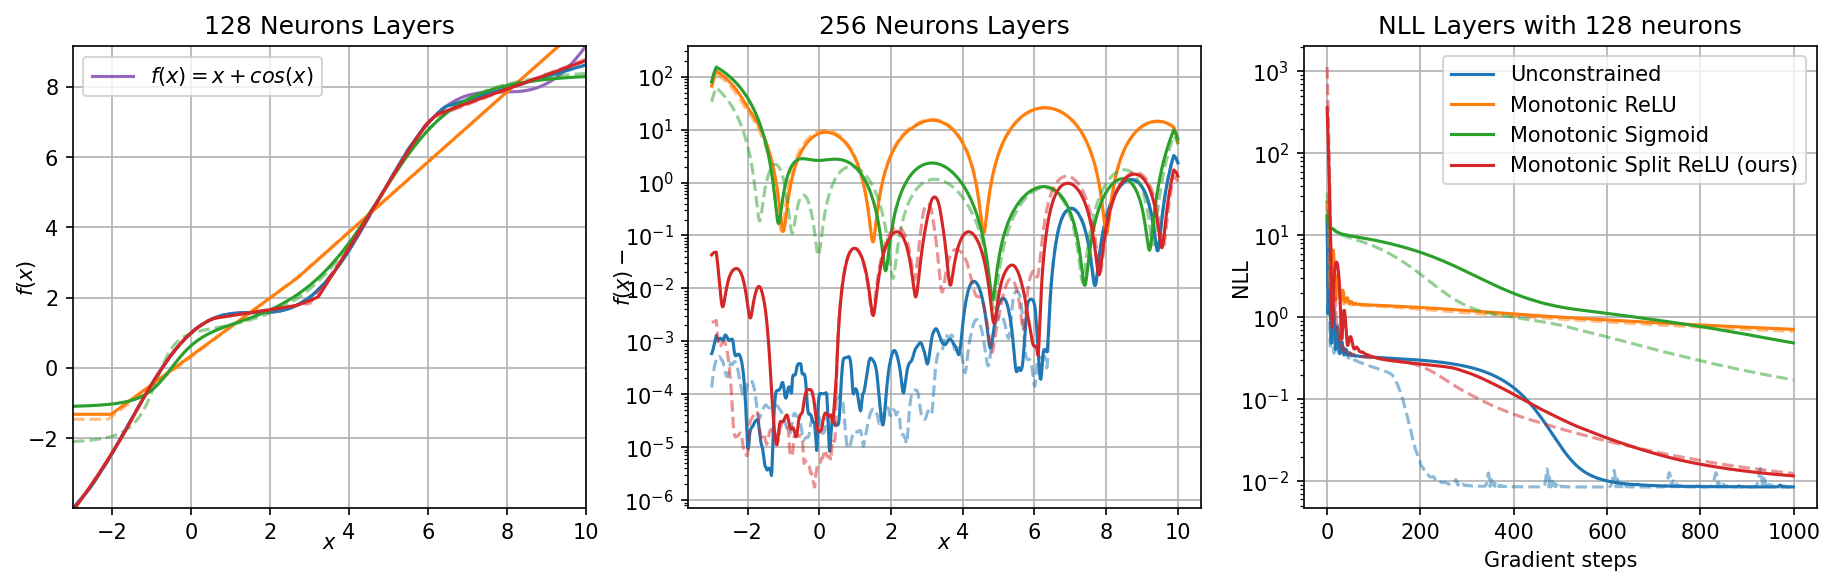

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=150)
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]
axs[0].plot(x,y, label="$f(x)=x+cos(x)$", c="C4")
axs[0].set_title("128 Neurons Layers")
axs[0].grid()
for i in range(len(models)):
    axs[0].plot(x, models[i][1](x).detach(), label=titles[i],c=f"C{i}",)
    axs[0].plot(x, models_other[i][1](x).detach(), label="_nolabel_", alpha=0.5, linestyle="dashed",c=f"C{i}",)
    axs[0].set_xlim(x.min(), x.max())
    axs[0].set_ylim(y.min(), y.max())
    axs[0].set_ylabel("$f(x)$", labelpad=-5)
    axs[0].set_xlabel("$x$", labelpad=-5)
axs[0].legend(["$f(x)=x+cos(x)$"])

axs[1].set_title("256 Neurons Layers")
axs[1].grid()
for i in range(len(models)):
    axs[1].semilogy(x, np.convolve(np.square(models[i][1](x).detach()-y).squeeze(), np.ones((20,)), mode="same"), label=titles[i],c=f"C{i}",)
    axs[1].semilogy(x, np.convolve(np.square(models_other[i][1](x).detach()-y).squeeze(), np.ones((20,)), mode="same"), label="_nolabel_", alpha=0.5, linestyle="dashed",c=f"C{i}",)
    axs[1].set_ylabel("$f(x) -$", labelpad=-5)
    axs[1].set_xlabel("$x$", labelpad=-5)
#axs[1].legend()



# for (_, loss), name in zip(model_losses.items(), titles):
#     axs[4].semilogy(loss, label=name)

# for (_, loss), name in zip(model_other_losses.items(), titles):
#     axs[5].semilogy(loss, label=name)
i = 0
for ((_, loss), (_, loss_other)), name in zip(zip(model_losses.items(), model_other_losses.items()), titles):
    axs[2].semilogy(loss, label=name, c=f"C{i}")
    axs[2].semilogy(loss_other, label="_nolabel_", c=f"C{i}", alpha=0.5, linestyle="dashed")
    i+=1

axs[2].set_ylabel("NLL", labelpad=-5)
#axs[5].set_ylabel("NLL", labelpad=-5)
axs[2].set_xlabel("Gradient steps")
#axs[5].set_xlabel("Gradient steps")

axs[2].set_title(f"NLL Layers with {DIM} neurons")
#axs[5].set_title(f"NLL Layers with {OTHERDIM} neurons")

axs[2].legend()
axs[2].grid()
#axs[5].legend()
#axs[5].grid()

plt.savefig("./joint_loss_comparison_accorpated.pdf", bbox_inches='tight')

/tmp/ipykernel_2517897/3592084059.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].semilogy(x, np.convolve(np.square(models[i][1](x).detach() - y).squeeze(), np.ones((20,)), mode="same"), label=titles[i], c=f"C{i}")
/tmp/ipykernel_2517897/3592084059.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].semilogy(x, np.convolve(np.square(models_other[i][1](x).detach() - y).squeeze(), np.ones((20,)), mode="same"), label="_nolabel_", alpha=0.5, linestyle="dashed", c=f"C{i}")


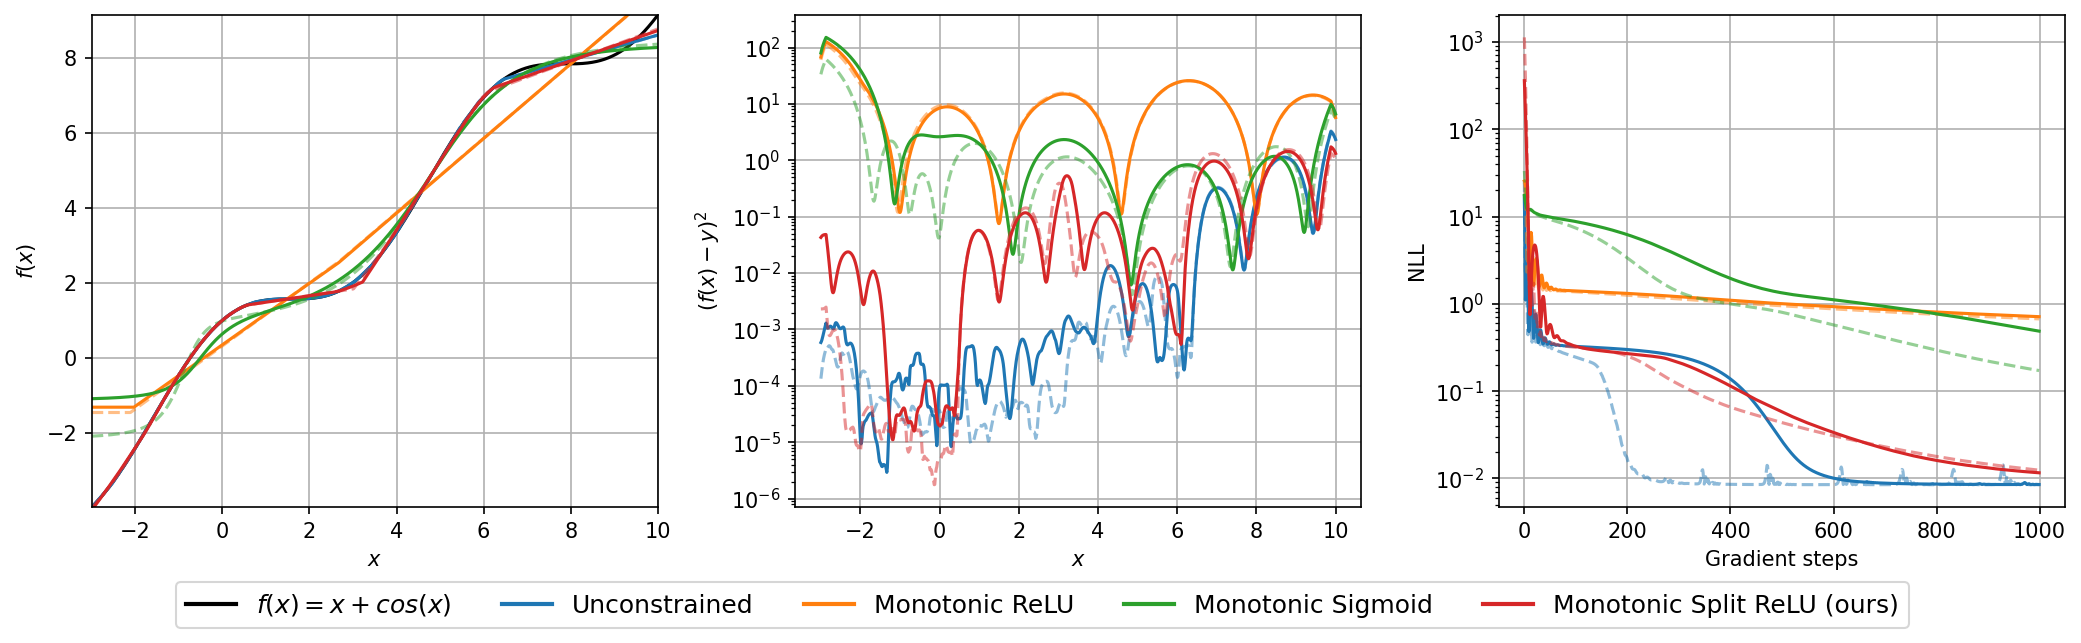

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=150, )
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]

# Plot for the first subplot
axs[0].plot(x, y, label="_nolabel_", c="black")

axs[0].grid()
for i in range(len(models)):
    axs[0].plot(x, models[i][1](x).detach(), label=titles[i], c=f"C{i}")
    axs[0].plot(x, models_other[i][1](x).detach(), label="_nolabel_", alpha=0.5, linestyle="dashed", c=f"C{i}")
    axs[0].set_xlim(x.min(), x.max())
    axs[0].set_ylim(y.min(), y.max())
    axs[0].set_ylabel("$f(x)$")
    axs[0].set_xlabel("$x$")



# Plot for the second subplot

axs[1].grid()
for i in range(len(models)):
    axs[1].semilogy(x, np.convolve(np.square(models[i][1](x).detach() - y).squeeze(), np.ones((20,)), mode="same"), label=titles[i], c=f"C{i}")
    axs[1].semilogy(x, np.convolve(np.square(models_other[i][1](x).detach() - y).squeeze(), np.ones((20,)), mode="same"), label="_nolabel_", alpha=0.5, linestyle="dashed", c=f"C{i}")
    axs[1].set_ylabel("$(f(x) - y)^2$")
    axs[1].set_xlabel("$x$")

# Plot for the third subplot
i = 0
for ((_, loss), (_, loss_other)), name in zip(zip(model_losses.items(), model_other_losses.items()), titles):
    axs[2].semilogy(loss, label=name, c=f"C{i}")
    axs[2].semilogy(loss_other, label="_nolabel_", c=f"C{i}", alpha=0.5, linestyle="dashed")
    i += 1

axs[2].set_ylabel("NLL")
axs[2].set_xlabel("Gradient steps")

axs[2].grid()

# Define custom legend handles
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Define custom legend handles
leg = [
    mlines.Line2D([], [], color='black', linewidth=2, label='$f(x)=x+cos(x)$'),
    mlines.Line2D([], [], color='C0', linewidth=2, label=titles[0]),
    mlines.Line2D([], [], color='C1', linewidth=2, label=titles[1]),
    mlines.Line2D([], [], color='C2', linewidth=2, label=titles[2]),
    mlines.Line2D([], [], color='C3', linewidth=2, label=titles[3]),
]


leg = fig.legend(
    handles=leg,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=5,
    fontsize=12
)
plt.tight_layout()

plt.savefig("./joint_loss_comparison_accorpated.pdf", bbox_inches='tight')
